# 🧠 Explainable Vision Transformer for Image Classification

## Data preprocessing

In [1]:
import numpy as np
from datasets import load_dataset
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import CenterCrop,Compose,Normalize,RandomHorizontalFlip,RandomResizedCrop,Resize,ToTensor
from torch.utils.data import DataLoader
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
#%pip install transformers==4.37.2
#%pip install accelerate==0.28.0
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/cisslab/anaconda3/envs/galluccio_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Used dataset: **CIFAR-10**
The dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
The dataset is divided into 5 training batches and one test batch, each with 10000 images, and the test batch contains exactly 1000 randomly-selected images from each class.

**I divided the train set in this way**:
* train set: 4/5
* validation set: 1/5

Each data is composed of two fields:
* ['img'] : Image object
* ['label'] : ClassLabel

In [2]:
"""
def prepare_dataset():
    #train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
    train_ds, test_ds = load_dataset('cifar10')
    splits = train_ds.train_test_split(test_size=0.2, seed=42)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds
"""
def prepare_dataset():
    train_ds, test_ds = load_dataset('cifar10', split=['train','test'])
    splits = train_ds.train_test_split(test_size=0.2, seed=42)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = prepare_dataset()
print(train_ds)
print(val_ds)
print(test_ds)

train_ds.features

Dataset({
    features: ['img', 'label'],
    num_rows: 40000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

Here, the first image (index 0) of the training set is shown, along with its label.

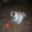

In [3]:
train_ds[0]['label']
id2label = {i: name for i, name in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
train_ds[0]['img']

In [4]:
label_name = id2label[train_ds[0]['label']]
print(f'Label: {label_name}')

Label: dog


To ensure the input image is compatible with ViT, we use the corresponding processor object to preprocess it.

In [ ]:
# load the processor to preprocess data
ViTprocessor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

/Users/cisslab/anaconda3/envs/galluccio_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We apply augmentation to the datas:
* ```RandomResizedCrop()```: We crop a random portion of the image and resize it to the specified size.
* ```RandomHorizontalFlip()```: Horizontally flip the image with a default probability of 0.5.
* ```ToTensor()```: We convert the image from a PIL Image to a tensor (ViT input format).
* ```Normalize```:  We normalize the data using the given mean and standard deviation values.

In [6]:
# We load the mean and standard deviation used to pre-train the ViT loaded from hugging face
# We use these values to process CIFAR-10 datas
image_mean, image_std = ViTprocessor.image_mean, ViTprocessor.image_std
size = ViTprocessor.size["height"]

normalize = Normalize(ViTprocessor.image_mean, ViTprocessor.image_std)

_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [7]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [8]:
# We pack the data in the following format:
# pixel values -> tensor
# labels -> tensor
# ready data for the model's training
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=16)

## Model Architecture and Training

We load **Data-efficient Image Transformer (DeiT)** model pre-trained on ImageNet-1k (1 million image and 1000 classes) at resolution 224x224. 

This model is actually a more efficiently trained Vision Transformer (ViT).

Source: [https://huggingface.co/facebook/deit-tiny-patch16-224]

In [ ]:
ViTmodel = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', 
                                                     num_labels=10,
                                                    id2label=id2label,
                                                    label2id=label2id,
                                                    ignore_mismatched_sizes=True)

# facebook/deit-tiny-patch16-224
## posso usare anche facebook/deit-small-patch16-224 che ha molti più parametri (più training time)

## Specify training arguments

args = TrainingArguments(
    #f"test-cifar-10",
    f"test-cifar-10-googlevit",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_score",
    logging_dir='logs',
    remove_unused_columns=False,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(
        eval_accuracy=accuracy_score(labels, predictions),
        eval_f1_score=f1_score(labels, predictions, average="weighted")
    )

trainer = Trainer(
    model=ViTmodel,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=ViTprocessor,
)

#model already trained and saved correctly on 'test-cifar-10/'
trainer.train()


/Users/cisslab/anaconda3/envs/galluccio_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
  7%|▋         | 500/7500 [02:36<36:05,  3.23it/s]

{'loss': 0.6715, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.2}


 13%|█▎        | 1000/7500 [05:11<33:08,  3.27it/s]

{'loss': 0.3201, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}


 20%|██        | 1500/7500 [07:45<30:53,  3.24it/s]

{'loss': 0.3078, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 27%|██▋       | 2000/7500 [10:19<28:29,  3.22it/s]

{'loss': 0.2825, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.8}


 33%|███▎      | 2500/7500 [12:54<25:18,  3.29it/s]

{'loss': 0.2775, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


                                                   
 33%|███▎      | 2500/7500 [13:51<25:18,  3.29it/s]

{'eval_accuracy': 0.9852, 'eval_f1_score': 0.9851850262148357, 'eval_loss': 0.049184758216142654, 'eval_runtime': 57.7413, 'eval_samples_per_second': 173.186, 'eval_steps_per_second': 10.824, 'epoch': 1.0}


 40%|████      | 3000/7500 [16:27<22:52,  3.28it/s]   

{'loss': 0.2571, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 47%|████▋     | 3500/7500 [19:03<20:50,  3.20it/s]

{'loss': 0.2585, 'learning_rate': 1.0666666666666667e-05, 'epoch': 1.4}


 53%|█████▎    | 4000/7500 [21:37<18:09,  3.21it/s]

{'loss': 0.2518, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}


 60%|██████    | 4500/7500 [24:11<15:26,  3.24it/s]

{'loss': 0.2255, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 67%|██████▋   | 5000/7500 [26:45<12:32,  3.32it/s]

{'loss': 0.2347, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                   
 67%|██████▋   | 5000/7500 [27:43<12:32,  3.32it/s]

{'eval_accuracy': 0.987, 'eval_f1_score': 0.9869993461972053, 'eval_loss': 0.04483676701784134, 'eval_runtime': 57.6602, 'eval_samples_per_second': 173.43, 'eval_steps_per_second': 10.839, 'epoch': 2.0}


 73%|███████▎  | 5500/7500 [30:19<10:26,  3.19it/s]   

{'loss': 0.2148, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.2}


 80%|████████  | 6000/7500 [32:54<07:42,  3.24it/s]

{'loss': 0.2066, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 87%|████████▋ | 6500/7500 [35:28<05:10,  3.22it/s]

{'loss': 0.2148, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.6}


 93%|█████████▎| 7000/7500 [38:03<02:35,  3.22it/s]

{'loss': 0.2198, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.8}


100%|██████████| 7500/7500 [40:38<00:00,  3.26it/s]

{'loss': 0.2122, 'learning_rate': 0.0, 'epoch': 3.0}


                                                   
100%|██████████| 7500/7500 [41:37<00:00,  3.26it/s]

{'eval_accuracy': 0.9883, 'eval_f1_score': 0.9882965690695553, 'eval_loss': 0.038828711956739426, 'eval_runtime': 58.4576, 'eval_samples_per_second': 171.064, 'eval_steps_per_second': 10.692, 'epoch': 3.0}


100%|██████████| 7500/7500 [41:38<00:00,  3.00it/s]

{'train_runtime': 2498.7582, 'train_samples_per_second': 48.024, 'train_steps_per_second': 3.001, 'train_loss': 0.2770046661376953, 'epoch': 3.0}


TrainOutput(global_step=7500, training_loss=0.2770046661376953, metrics={'train_runtime': 2498.7582, 'train_samples_per_second': 48.024, 'train_steps_per_second': 3.001, 'train_loss': 0.2770046661376953, 'epoch': 3.0})

## Evaluation and Results

In [13]:
trainer = Trainer(
    model=ViTForImageClassification.from_pretrained("test-cifar-10-googlevit/checkpoint-7500"),
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=ViTprocessor,
)

results = trainer.evaluate(val_ds)
print("\nEvaluation Metrics")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"F1 Score: {results['eval_f1_score']:.4f}")
print(f"Loss: {results['eval_loss']:.4f}")

/Users/cisslab/anaconda3/envs/galluccio_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
100%|██████████| 625/625 [00:58<00:00, 10.68it/s]


Evaluation Metrics
Accuracy: 0.9883
F1 Score: 0.9883
Loss: 0.0388


In [14]:
outputs = trainer.predict(test_ds)
for metric, value in outputs.metrics.items():
    print(f"{metric}: {value:.4f}")

100%|██████████| 625/625 [00:58<00:00, 10.70it/s]

test_loss: 0.0476
test_eval_accuracy: 0.9857
test_eval_f1_score: 0.9857
test_runtime: 58.6039
test_samples_per_second: 170.6370
test_steps_per_second: 10.6650


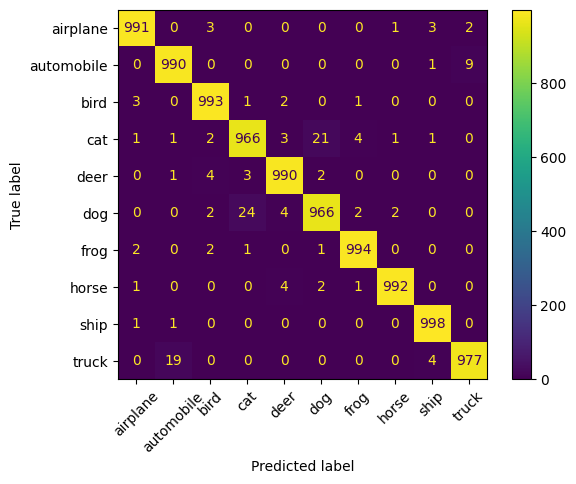

In [15]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

## Explainable Visualization 

In [16]:
ID2CLS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

``` show_cam_on_image```: Applies a heatmap overlay to a test image, helping us visualize which regions most influenced the model’s decision.

```print_top_classes(predictions)```: Applies a softmax to the model’s output logits, retrieves the top 10 most probable classes for the input image, and prints each class name alongside its probability percentage.

In [17]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# compute the probability of all the classes to be assigned to a test image, thourgh softmax
def print_top_classes(predictions):
    probs = torch.softmax(predictions, dim=-1)
    class_indices = predictions.data.topk(10, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(ID2CLS[cls_idx])
        if len(ID2CLS[cls_idx]) > max_str_len:
            max_str_len = len(ID2CLS[cls_idx])
    print(f'Probability on all the classes:')
    for cls_idx in class_indices:
        output_string = '\t{}'.format(ID2CLS[cls_idx])
        output_string += ' ' * (max_str_len - len(ID2CLS[cls_idx])) + '\t'
        output_string += 'prob = {:.1f}%'.format(100 * probs[0, cls_idx])
        print(output_string)

```attention_rollout(attention, discard_radio)```: Attention rollout is a method for visualizing the attention mechanism in Transformer models. It addresses the issue that attention weights in deeper layers of Transformer models become increasingly mixed and less interpretable.

The key idea behind attention rollout is to recursively compute the token attentions in each layer of the Transformer by multiplying the attention matrices across layers. This allows the attention signal to be propagated through the entire network, rather than just being visible in the first few layers.

We use **discard ratio** to discard the smallest values in the attention matrices

In [18]:
def attention_rollout(attentions, discard_ratio):
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    for attn in attentions:
        attn_heads_fused = attn[0].mean(0)
        
        if discard_ratio > 0:
            flat = attn_heads_fused.view(-1)
            _, indices = flat.topk(int(flat.size(0) * discard_ratio), largest=False)
            flat[indices] = 0
            attn_heads_fused = flat.view(attn_heads_fused.size())

        attn_heads_fused += torch.eye(attn_heads_fused.size(0)).to(attn_heads_fused.device)
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn_heads_fused, result)
    mask = result[0, 1:]
    return mask

In [19]:
def generate_visualization(pil_image, outputs, logits):

    attentions = outputs.attentions
    probs = torch.softmax(logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()
    label = ID2CLS.get(pred_class, str(pred_class))

    mask = attention_rollout(attentions, discard_ratio = 0.4)
    num_patches = mask.shape[0]
    size = int(num_patches ** 0.5)
    mask = mask.reshape(1, 1, size, size)

    cam = torch.nn.functional.interpolate(mask, scale_factor=16, mode='bilinear').squeeze().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    image_np = np.array(pil_image.resize((224, 224))).astype(np.float32) / 255.0
    cam_overlay = show_cam_on_image(image_np, cam)

    return cam_overlay, label


Predicted class (with heatmap): cat


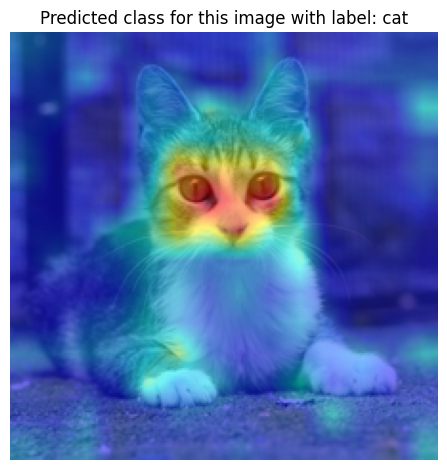

Probability on all the classes:
	cat       	prob = 99.9%
	dog       	prob = 0.0%
	bird      	prob = 0.0%
	frog      	prob = 0.0%
	deer      	prob = 0.0%
	automobile	prob = 0.0%
	ship      	prob = 0.0%
	airplane  	prob = 0.0%
	truck     	prob = 0.0%
	horse     	prob = 0.0%


In [22]:
model_name = 'test-cifar-10-googlevit/checkpoint-7500'
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)
processor = ViTImageProcessor.from_pretrained(model_name)
model.eval()

file_path = "test_img/cat3.png"
image = Image.open(file_path)
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits


vis, label = generate_visualization(image, outputs, predictions)

print(f"\nPredicted class (with heatmap): {label}")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class for this image with label: {label}")
plt.axis("off")
plt.tight_layout()
plt.show()
print_top_classes(predictions)